# Assignment 3 Part 2
## Diffusion Model

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# For Google Colab, commented out since running locally
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/A3_PartB/  #Use correct path
# !pwd

In [3]:
# Verify the AFHQ dataset is present
import os

data_path = './data/train'
if os.path.exists(data_path):
    print("✅ Dataset found!")
    print(f"📁 Data structure:")
    for category in ['cat', 'dog', 'wild']:
        cat_path = os.path.join(data_path, category)
        if os.path.exists(cat_path):
            num_images = len([f for f in os.listdir(cat_path) if f.endswith(('.jpg', '.png'))])
            print(f"   - {category}: {num_images} images")
else:
    print("❌ Dataset not found at ./data/train")
    print("Please download the AFHQ dataset manually and place it in the ./data folder")

✅ Dataset found!
📁 Data structure:
   - cat: 5065 images
   - dog: 4678 images
   - wild: 4593 images


In [ ]:
# Download the dataset afhq_v2.zip (6.48G)
!mkdir -p ./data
!gdown --id 1-1npXlqCw1CYQ5SBbrlSgZdA9TEwZre4 -O ./data/afhq_v2.zip #Using gdown to get the data from Google Drive location
!unzip -q ./data/afhq_v2.zip -d ./data

In [ ]:
# Download the dataset afhq_v2.zip (6.48G) - OR use the one provided in the data folder
!mkdir -p /content/data
!wget -N https://www.dropbox.com/s/vkzjokiwof5h8w6/afhq_v2.zip?dl=0 -O /content/data/afhq_v2.zip
!unzip -q /content/data/afhq_v2.zip -d /content/data

In [5]:
# Set up the environment
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
# Quick test (100 steps, ~1-2 minutes) with real-time progress
import subprocess
import sys
import os

os.environ['WANDB_MODE'] = 'disabled'

process = subprocess.Popen(
    [sys.executable, 'main.py',
     '--data_path', './data/train',
     '--save_folder', './test_run',
     '--time_steps', '10',
     '--train_steps', '10',
     '--image_size', '32',
     '--batch_size', '4',
     '--learning_rate', '1e-3',
     '--unet_dim', '16',
     '--save_and_sample_every', '5'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1,
    universal_newlines=True
)

# Stream output line by line in real-time
for line in iter(process.stdout.readline, ''):
    if line:
        print(line, end='', flush=True)

return_code = process.wait()

if return_code == 0:
    print("\n✅ Test completed successfully!")
else:
    print(f"\n❌ Test failed with error code: {return_code}")

Namespace(time_steps=10, train_steps=10, save_folder='./test_run', data_path='./data/train', load_path=None, data_class='cat', image_size=32, batch_size=4, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=False, save_and_sample_every=5, visualize=False)
dataset length: 5065, dataset class: cat

[==========] 100% | Step 10/10 | Loss: 0.6817 | Elapsed: 0.1min | ETA: 0.0min
training completed

✅ Test completed successfully!


In [32]:
# Quick test Visualize the forward and backward diffusion process
import os

os.environ['WANDB_MODE'] = 'disabled'

!python main.py --data_path ./data/train/ --load_path ./test_run/model.pt --save_folder ./test_run --time_steps 10 --image_size 32 --batch_size 4 --learning_rate 1e-3 --unet_dim 16 --visualize

Namespace(time_steps=10, train_steps=50000, save_folder='./test_run', data_path='./data/train/', load_path='./test_run/model.pt', data_class='cat', image_size=32, batch_size=4, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=False, save_and_sample_every=1000, visualize=True)
dataset length: 5065, dataset class: cat
Loading :  ./test_run/model.pt
✅ Forward and backward diffusion images generated (wandb disabled)
   Forward diffusion: 5 images
   Backward diffusion: 5 images


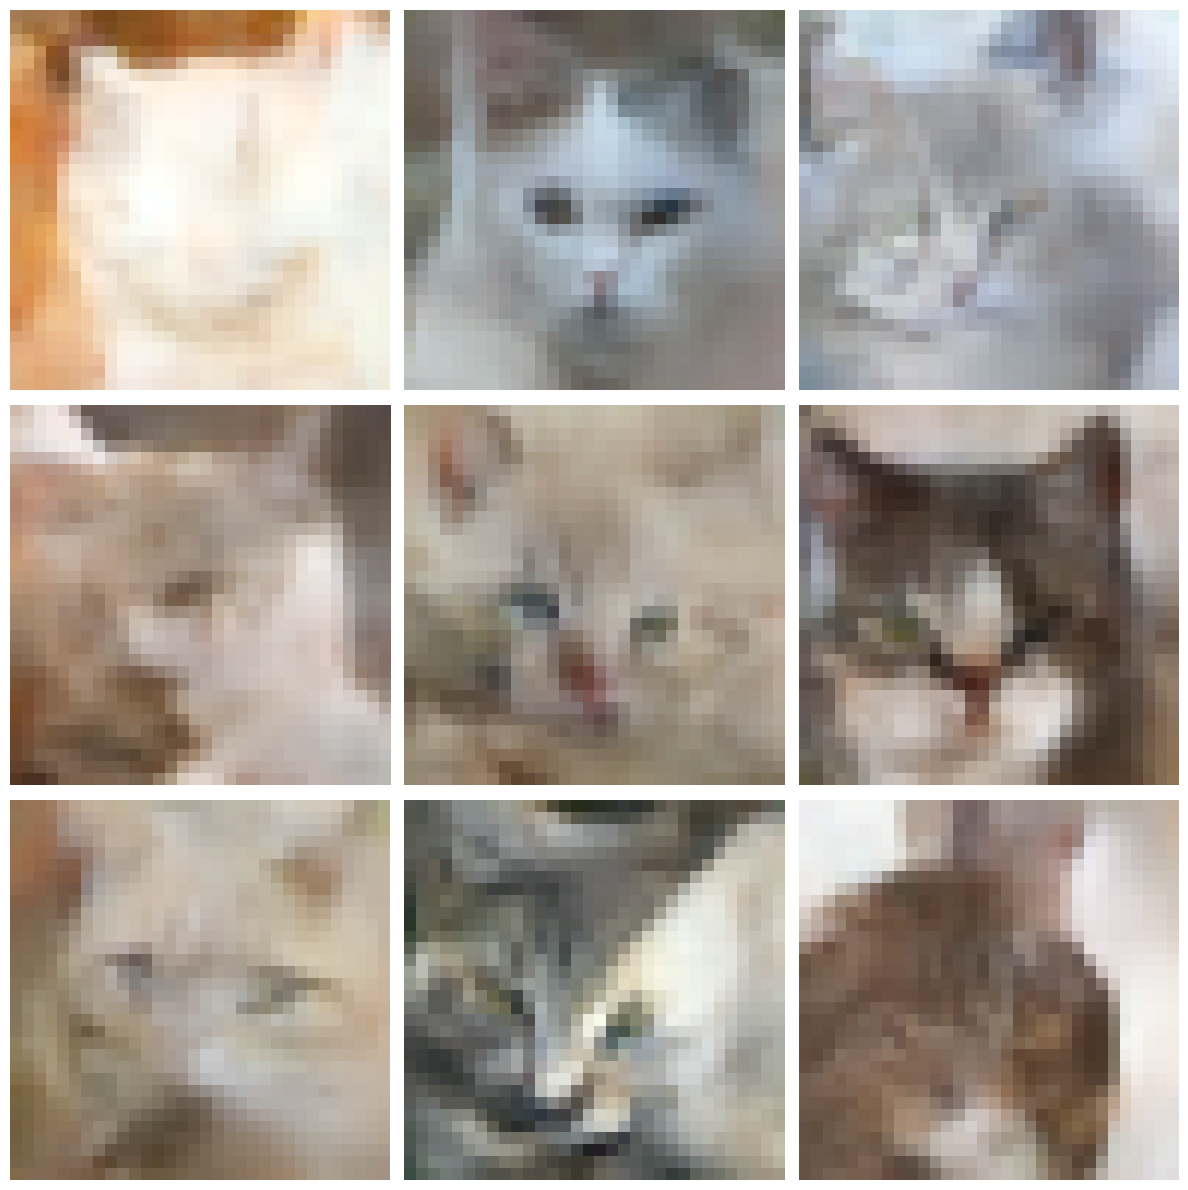

In [33]:
# Display generated samples
import matplotlib.pyplot as plt
from PIL import Image
import os

results_path = './results_afhq'  # Change to './test_run' for quick test results

# Get sample folders
sample_folders = sorted([d for d in os.listdir(results_path) 
                        if os.path.isdir(os.path.join(results_path, d)) and d.startswith('sample_ddpm_')])

if sample_folders:
    # Display 9 samples from the last checkpoint
    last_folder = os.path.join(results_path, sample_folders[-1])
    sample_images = sorted([f for f in os.listdir(last_folder) if f.endswith('.png')])[:9]
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(sample_images):
        img = Image.open(os.path.join(last_folder, img_file))
        axes[idx].imshow(img)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [34]:
# FULL SCALE TRAINING: Train the model (will take ~1-2 hours)
import subprocess
import sys
import os

os.environ['WANDB_MODE'] = 'disabled'

process = subprocess.Popen(
    [sys.executable, 'main.py',
     '--data_path', './data/train',
     '--save_folder', './results_afhq',
     '--time_steps', '50',
     '--train_steps', '10000',
     '--image_size', '32',
     '--batch_size', '32',
     '--learning_rate', '1e-3',
     '--unet_dim', '16',
     '--save_and_sample_every', '500'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

for line in iter(process.stdout.readline, ''):
    if line:
        print(line, end='', flush=True)

if process.wait() == 0:
    print("\n✅ Training completed successfully!")

Namespace(time_steps=50, train_steps=10000, save_folder='./results_afhq', data_path='./data/train', load_path=None, data_class='cat', image_size=32, batch_size=32, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=False, save_and_sample_every=500, visualize=False)
dataset length: 5065, dataset class: cat

[=---------] 10% | Step 1000/10000 | Loss: 0.1669 | Elapsed: 9.0min | ETA: 80.7min
[==--------] 20% | Step 2000/10000 | Loss: 0.1402 | Elapsed: 18.2min | ETA: 72.8min
[===-------] 30% | Step 3000/10000 | Loss: 0.1623 | Elapsed: 27.4min | ETA: 64.0min
[====------] 40% | Step 4000/10000 | Loss: 0.1491 | Elapsed: 36.6min | ETA: 55.0min
[=====-----] 50% | Step 5000/10000 | Loss: 0.1487 | Elapsed: 45.9min | ETA: 45.9min
[======----] 60% | Step 6000/10000 | Loss: 0.1426 | Elapsed: 55.3min | ETA: 36.9min
[=======---] 70% | Step 7000/10000 | Loss: 0.1471 | Elapsed: 65.2min | ETA: 28.0min
[========--] 80% | Step 8000/10000 | Loss: 0.1614 | Elapsed: 75.1min | ETA: 18.8min
[====

In [35]:
# Visualize forward and backward diffusion
import subprocess
import sys
import os

os.environ['WANDB_MODE'] = 'disabled'

process = subprocess.Popen(
    [sys.executable, 'main.py',
     '--data_path', './data/train/',
     '--load_path', './results_afhq/model.pt',
     '--save_folder', './results_afhq',
     '--time_steps', '50',
     '--image_size', '32',
     '--batch_size', '32',
     '--learning_rate', '1e-3',
     '--unet_dim', '16',
     '--visualize'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

for line in iter(process.stdout.readline, ''):
    if line:
        print(line, end='', flush=True)

if process.wait() == 0:
    print("\n✅ Visualization completed!")

Namespace(time_steps=50, train_steps=50000, save_folder='./results_afhq', data_path='./data/train/', load_path='./results_afhq/model.pt', data_class='cat', image_size=32, batch_size=32, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=False, save_and_sample_every=1000, visualize=True)
dataset length: 5065, dataset class: cat
Loading :  ./results_afhq/model.pt
âœ… Forward and backward diffusion images generated (wandb disabled)
   Forward diffusion: 5 images
   Backward diffusion: 5 images

✅ Visualization completed!


🖼️  Displaying Diffusion Visualization Results
Found 1 sample images



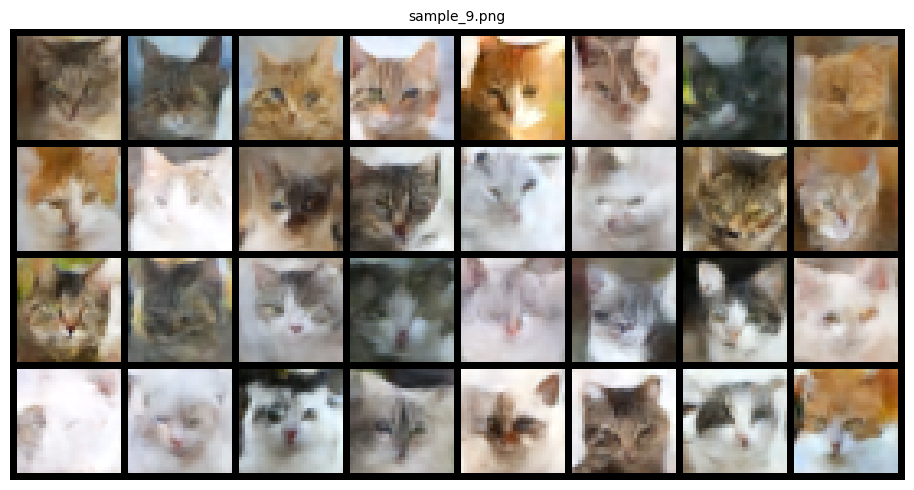


📁 Found 10 checkpoint folders:
   - sample_ddpm_0: 1024 images
   - sample_ddpm_1: 512 images
   - sample_ddpm_2: 512 images
   - sample_ddpm_3: 512 images
   - sample_ddpm_4: 512 images
   - sample_ddpm_5: 512 images
   - sample_ddpm_6: 512 images
   - sample_ddpm_7: 512 images
   - sample_ddpm_8: 512 images
   - sample_ddpm_9: 512 images

🎨 Displaying 9 samples from sample_ddpm_9 (final checkpoint):


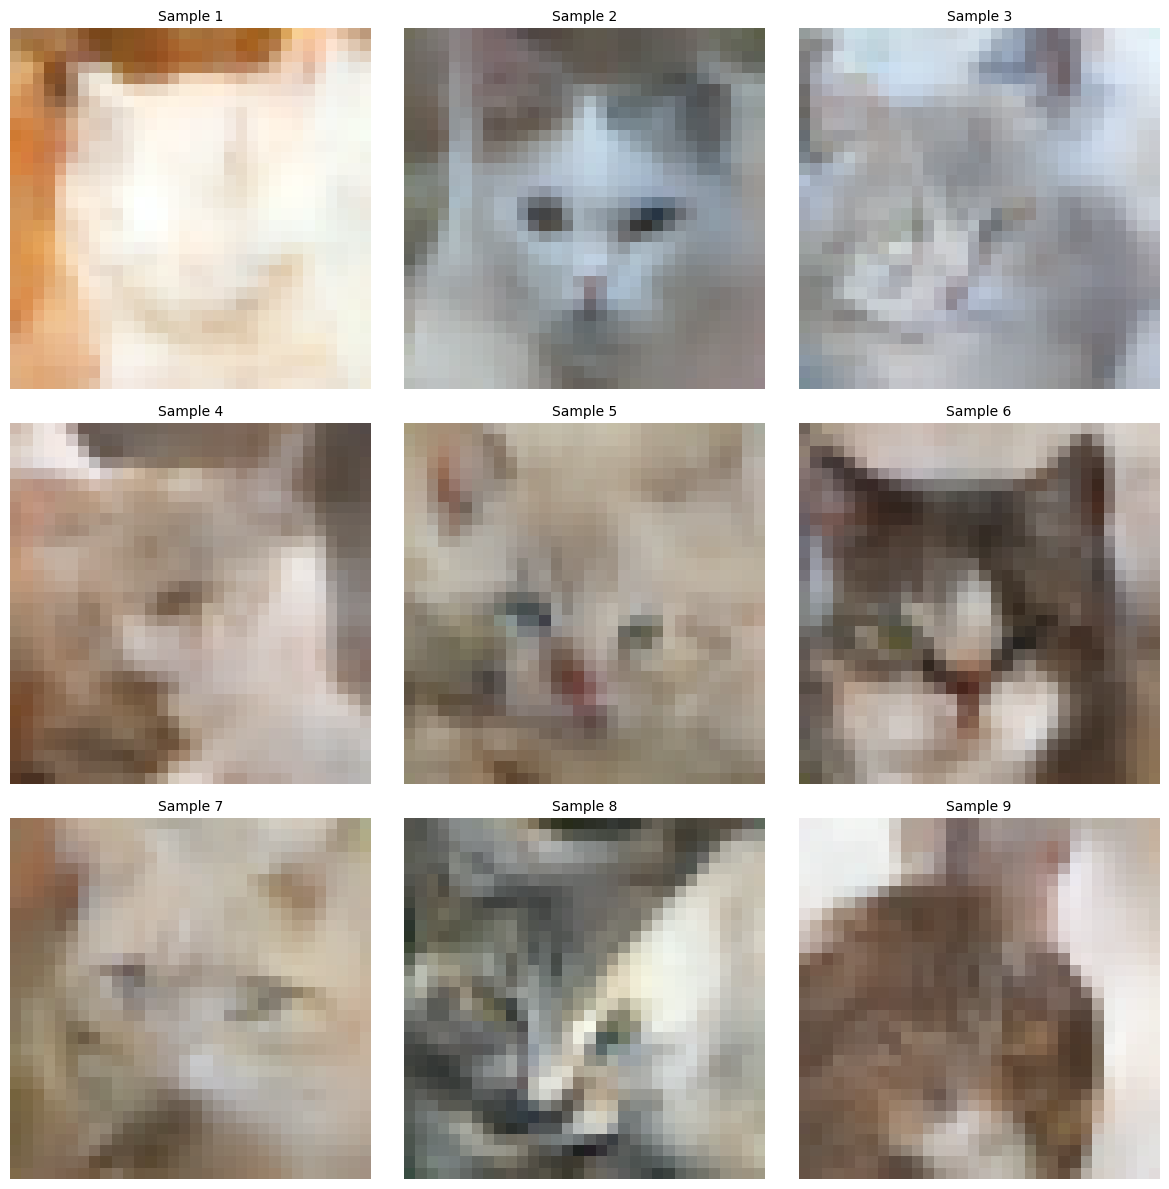

✅ Visualization complete!

The forward diffusion shows: clean image → progressively noisier
The backward diffusion shows: pure noise → progressively cleaner (denoising)


In [ ]:
# Display generated samples from trained model
import matplotlib.pyplot as plt
from PIL import Image
import os

results_path = './results_afhq'

# Get sample folders
sample_folders = sorted([d for d in os.listdir(results_path) 
                        if os.path.isdir(os.path.join(results_path, d)) and d.startswith('sample_ddpm_')])

if sample_folders:
    # Display 9 samples from the last checkpoint (best trained model)
    last_folder = os.path.join(results_path, sample_folders[-1])
    sample_images = sorted([f for f in os.listdir(last_folder) if f.endswith('.png')])[:9]
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(sample_images):
        img = Image.open(os.path.join(last_folder, img_file))
        axes[idx].imshow(img)
        axes[idx].axis('off')
    
    plt.suptitle(f'Generated Cat Faces - {sample_folders[-1]}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [36]:
# Visualize the forward and backward process
!python main.py --data_path ./data/train/ --load_path ./results_afhq/model.pt --save_folder ./results_afhq --time_steps 50 --train_steps 5000 --image_size 32 --batch_size 32 --learning_rate 1e-3 --unet_dim 16 --visualize

Namespace(time_steps=50, train_steps=5000, save_folder='./results_afhq', data_path='./data/train/', load_path='./results_afhq/model.pt', data_class='cat', image_size=32, batch_size=32, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=False, save_and_sample_every=1000, visualize=True)
dataset length: 5065, dataset class: cat
Loading :  ./results_afhq/model.pt
✅ Forward and backward diffusion images generated (wandb disabled)
   Forward diffusion: 5 images
   Backward diffusion: 5 images
